In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinModel
from transformers.models.swin.modeling_swin import SwinLayer

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# --- Cài đặt tham số cố định ---
IMG_SIZE = 320 # Swin-Unet yêu cầu kích thước ảnh chia hết cho 32
BATCH_SIZE = 2 
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
SEED = 42

# --- Thiết lập Seed để có kết quả lặp lại ---
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Đường dẫn dữ liệu (Thay đổi nếu cần) ---
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

# --- Thu thập đường dẫn tệp ảnh và mask ---
train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


In [2]:
class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transform=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 0, 255.0, 0.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        mask = mask / 255.0
        mask = mask.unsqueeze(0)

        return img, mask

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
# --- 4. KIẾN TRÚC MÔ HÌNH (SỬA LỖI LOGIC HOÀN CHỈNH) ---

class SkipAttention(nn.Module):
    def __init__(self, in_channels, key_channels, head_count=8):
        super().__init__()
        self.head_count = head_count
        
        self.scale = (key_channels // head_count) ** -0.5
        
        self.to_q = nn.Linear(in_channels, key_channels, bias=False)
        self.to_k = nn.Linear(in_channels, key_channels, bias=False)
        self.to_v = nn.Linear(in_channels, in_channels, bias=False)
        self.unifyheads = nn.Linear(in_channels, in_channels)

    def forward(self, query, context):
        B, L_q, C_q = query.shape
        _, L_c, C_c = context.shape
        
        q = self.to_q(query)
        k = self.to_k(context)
        v = self.to_v(context)
        
        q = q.view(B, L_q, self.head_count, -1).transpose(1, 2)
        k = k.view(B, L_c, self.head_count, -1).transpose(1, 2)
        v = v.view(B, L_c, self.head_count, -1).transpose(1, 2)
        
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_probs = F.softmax(attn_scores, dim=-1)
        
        output = torch.matmul(attn_probs, v).transpose(1, 2).contiguous().view(B, L_q, -1)
        return self.unifyheads(output)

class PatchExpanding(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer=nn.LayerNorm):
        super().__init__()
        # **SỬA LỖI**: Phải chiếu thành 4 * out_channels để sắp xếp lại không gian
        self.expand = nn.Linear(in_channels, 4 * out_channels, bias=False)
        self.norm = norm_layer(out_channels)

    def forward(self, x):
        x = self.expand(x)
        B, L, C = x.shape
        H = W = int(np.sqrt(L))
        
        # Reshape C thành C_out và grid 2x2
        x = x.view(B, H, W, 2, 2, C // 4)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(B, -1, C // 4)
        
        x = self.norm(x)
        return x

class SwinUNet_v2(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, img_size=320):
        super().__init__()
        self.img_size = img_size
        
        # --- THAY ĐỔI 1: Tải mô hình Swin-Tiny ---
        self.swin = SwinModel.from_pretrained(
            "microsoft/swin-tiny-patch4-window7-224",
            image_size=self.img_size, output_hidden_states=True, output_attentions=False
        )
        
        self.main_config = self.swin.config
        embed_dim = self.main_config.embed_dim
        depths = self.main_config.depths
        self.encoder_channels = [embed_dim * (2**i) for i in range(len(depths))]
        self.num_heads = self.main_config.num_heads
        
        print(f"Using Swin-Tiny backbone. All SwinLayers will use a fixed window_size = {self.main_config.window_size}")
        print(f"Encoder channels: {self.encoder_channels}") # In ra để kiểm tra
        print(f"Num heads: {self.num_heads}")

        bottleneck_depth = 2
        self.bottleneck = nn.ModuleList([
            SwinLayer(config=self.main_config,
                      dim=self.encoder_channels[3], 
                      input_resolution=(self.img_size//32, self.img_size//32),
                      num_heads=self.num_heads[3],
                      shift_size=0 if (i % 2 == 0) else self.main_config.window_size // 2)
            for i in range(bottleneck_depth)])
        
        # --- SỬA LỖI & CẢI TIẾN LOGIC CHO CÁC LỚP FUSE ---
        
        # --- DECODER 4 ---
        self.decoder4_expand = PatchExpanding(self.encoder_channels[3], self.encoder_channels[2])
        self.skip_attn4 = SkipAttention(self.encoder_channels[2], self.encoder_channels[2])
        # Sửa: input_dim = 2 * channel[2] vì đây là kết quả của concatenation
        self.decoder4_fuse = nn.Linear(2 * self.encoder_channels[2], self.encoder_channels[2]) 
        self.decoder4_swin = nn.ModuleList([
            SwinLayer(config=self.main_config,
                    dim=self.encoder_channels[2],
                    input_resolution=(self.img_size//16, self.img_size//16),
                    num_heads=self.num_heads[2],
                    shift_size=0 if (i % 2 == 0) else self.main_config.window_size // 2)
            for i in range(depths[2])])

        # --- DECODER 3 ---
        self.decoder3_expand = PatchExpanding(self.encoder_channels[2], self.encoder_channels[1])
        self.skip_attn3 = SkipAttention(self.encoder_channels[1], self.encoder_channels[1])
        # Sửa: input_dim = 2 * channel[1]
        self.decoder3_fuse = nn.Linear(2 * self.encoder_channels[1], self.encoder_channels[1])
        self.decoder3_swin = nn.ModuleList([
            SwinLayer(config=self.main_config,
                    dim=self.encoder_channels[1],
                    input_resolution=(self.img_size//8, self.img_size//8),
                    num_heads=self.num_heads[1],
                    shift_size=0 if (i % 2 == 0) else self.main_config.window_size // 2)
            for i in range(depths[1])])

        # --- DECODER 2 ---
        self.decoder2_expand = PatchExpanding(self.encoder_channels[1], self.encoder_channels[0])
        self.skip_attn2 = SkipAttention(self.encoder_channels[0], self.encoder_channels[0])
        # Sửa: input_dim = 2 * channel[0]
        self.decoder2_fuse = nn.Linear(2 * self.encoder_channels[0], self.encoder_channels[0])
        self.decoder2_swin = nn.ModuleList([
            SwinLayer(config=self.main_config,
                    dim=self.encoder_channels[0],
                    input_resolution=(self.img_size//4, self.img_size//4),
                    num_heads=self.num_heads[0],
                    shift_size=0 if (i % 2 == 0) else self.main_config.window_size // 2)
            for i in range(depths[0])])

        # Các lớp cuối giữ nguyên
        self.final_norm = nn.LayerNorm(self.encoder_channels[0])
        self.final_conv = nn.Conv2d(self.encoder_channels[0], num_classes, kernel_size=1)

    # Hàm forward của bạn đã đúng, không cần thay đổi
    def forward(self, x):
        input_size = x.shape[2:]
        outputs = self.swin(pixel_values=x, output_hidden_states=True)
        
        hidden_states = outputs.hidden_states
        
        s1 = hidden_states[0]
        s2 = hidden_states[1]
        s3 = hidden_states[2]
        s4 = hidden_states[3]

        # --- Bottleneck ---
        b_out = s4
        for layer in self.bottleneck:
            b_out = layer(b_out, (self.img_size//32, self.img_size//32))[0] 
        
        # --- Decoder 4 ---
        d4_up = self.decoder4_expand(b_out)
        s3_refined = self.skip_attn4(query=d4_up, context=s3)
        d4_cat = torch.cat([d4_up, s3_refined], dim=-1)
        d4_fused = self.decoder4_fuse(d4_cat)
        d4_out = d4_fused
        for layer in self.decoder4_swin:
            d4_out = layer(d4_out, (self.img_size//16, self.img_size//16))[0]
        
        # --- Decoder 3 ---
        d3_up = self.decoder3_expand(d4_out)
        s2_refined = self.skip_attn3(query=d3_up, context=s2)
        d3_cat = torch.cat([d3_up, s2_refined], dim=-1)
        d3_fused = self.decoder3_fuse(d3_cat)
        d3_out = d3_fused
        for layer in self.decoder3_swin:
            d3_out = layer(d3_out, (self.img_size//8, self.img_size//8))[0]

        # --- Decoder 2 ---
        d2_up = self.decoder2_expand(d3_out)
        s1_refined = self.skip_attn2(query=d2_up, context=s1)
        d2_cat = torch.cat([d2_up, s1_refined], dim=-1)
        d2_fused = self.decoder2_fuse(d2_cat)
        d2_out = d2_fused
        for layer in self.decoder2_swin:
            d2_out = layer(d2_out, (self.img_size//4, self.img_size//4))[0]

        # --- Final Layers ---
        final_features = self.final_norm(d2_out)
        B, L, C = final_features.shape
        H = W = int(np.sqrt(L))
        final_features = final_features.permute(0, 2, 1).contiguous().view(B, C, H, W)
        
        output = self.final_conv(final_features)
        output = F.interpolate(output, size=input_size, mode='bilinear', align_corners=False)
        
        return output

In [4]:

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs là logits từ model, cần đưa qua sigmoid để có xác suất (0, 1)
        inputs = torch.sigmoid(inputs)
        
        # Làm phẳng inputs và targets để tính toán dễ dàng
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Tính toán intersection (phần giao) và union (phần hợp)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        # Tính IoU, thêm smooth để tránh chia cho 0
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Loss là phần bù của IoU
        return 1 - iou


def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    predicted_masks = predicted_masks.view(-1)
    true_masks = true_masks.view(-1)
    
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / (predicted_masks.sum() + true_masks.sum() + smooth)
    
    return iou.item(), dice.item()

In [5]:
# --- Vòng lặp huấn luyện (Đã chỉnh sửa chỉ dùng IoU) ---
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_iou=0.0, history=None):
    best_iou = best_val_iou
    patience_counter = 0
    checkpoint_path = callbacks_config.get('checkpoint_path', 'model_best.pth')
    
    # Sửa đổi: Chỉ lưu loss và iou
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': [], 'lr': []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        # Sửa đổi: Bỏ train_dice
        train_loss, train_iou = 0.0, 0.0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            
            # Sửa đổi: Chỉ lấy iou, bỏ qua dice
            batch_iou, _ = calculate_metrics(predicted_masks, masks)
            train_iou += batch_iou
            
            # Sửa đổi: Bỏ dice khỏi thanh tiến trình
            loop.set_postfix(loss=loss.item(), iou=batch_iou)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_iou'].append(train_iou / len(train_loader))
        # Sửa đổi: Bỏ history cho train_dice

        model.eval()
        # Sửa đổi: Bỏ val_dice
        val_loss, val_iou = 0.0, 0.0
        
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, masks in loop:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                
                # Sửa đổi: Chỉ lấy iou, bỏ qua dice
                batch_iou, _ = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        # Sửa đổi: Bỏ history cho val_dice
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1} Summary:")
        # Sửa đổi: Bỏ Dice khỏi bản tóm tắt
        print(f"  Train -> Loss: {history['train_loss'][-1]:.4f}, IoU: {history['train_iou'][-1]:.4f}")
        print(f"  Val   -> Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}")
        print(f"  LR: {current_lr:.8f}")

        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            patience_counter = 0
            print(f"🚀 New best validation IoU: {best_iou:.4f}. Saving model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_iou': best_iou,
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history
            }, checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation IoU did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
    return history

# --- Hàm vẽ biểu đồ (Đã chỉnh sửa chỉ dùng IoU) ---
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Sửa đổi: Tạo một hàng 3 cột cho 3 biểu đồ
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Biểu đồ 1: Loss
    axs[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axs[0].plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    # Biểu đồ 2: IoU
    axs[1].plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    axs[1].plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    axs[1].set_title('Training and Validation IoU')
    axs[1].set(xlabel='Epoch', ylabel='IoU')
    axs[1].legend()

    axs[2].plot(epochs, history['lr'], 'o-', label='Learning Rate', color='purple')
    axs[2].set_title('Learning Rate per Epoch')
    axs[2].set(xlabel='Epoch', ylabel='Learning Rate')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

Using Swin-Tiny backbone. All SwinLayers will use a fixed window_size = 7
Encoder channels: [96, 192, 384, 768]
Num heads: [3, 6, 12, 24]
!!! USING BCEWithLogitsLoss with pos_weight=20 !!!
Model: SwinUNet_v2 initialized with 56,191,093 trainable parameters.
Checkpoint found at swin_unet_v2.pth. Loading to resume training...


C:\Users\Admin\AppData\Local\Temp\ipykernel_3640\3257955449.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.

Resuming training from Epoch 23.
Best validation IoU so far: 0.3865

--- Starting Swin-UNet v2 Training (BCE loss with pos_weight) ---


Epoch 24/100 [Val]: 100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


Epoch 24 Summary:
  Train -> Loss: 0.1288, IoU: 0.4263
  Val   -> Loss: 0.2543, IoU: 0.3642
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/20


Epoch 25/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.13it/s]


Epoch 25 Summary:
  Train -> Loss: 0.1255, IoU: 0.4325
  Val   -> Loss: 0.2267, IoU: 0.3637
  LR: 0.00005000
Validation IoU did not improve. Patience: 2/20


Epoch 26/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


Epoch 26 Summary:
  Train -> Loss: 0.1246, IoU: 0.4319
  Val   -> Loss: 0.2539, IoU: 0.3779
  LR: 0.00005000
Validation IoU did not improve. Patience: 3/20


Epoch 27/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.13it/s]


Epoch 27 Summary:
  Train -> Loss: 0.1276, IoU: 0.4275
  Val   -> Loss: 0.2171, IoU: 0.3773
  LR: 0.00002500
Validation IoU did not improve. Patience: 4/20


Epoch 28/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.06it/s]


Epoch 28 Summary:
  Train -> Loss: 0.1207, IoU: 0.4408
  Val   -> Loss: 0.2176, IoU: 0.3733
  LR: 0.00002500
Validation IoU did not improve. Patience: 5/20


Epoch 29/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.06it/s]


Epoch 29 Summary:
  Train -> Loss: 0.1173, IoU: 0.4423
  Val   -> Loss: 0.2550, IoU: 0.3924
  LR: 0.00002500
🚀 New best validation IoU: 0.3924. Saving model...


Epoch 30/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


Epoch 30 Summary:
  Train -> Loss: 0.1173, IoU: 0.4444
  Val   -> Loss: 0.2519, IoU: 0.3981
  LR: 0.00002500
🚀 New best validation IoU: 0.3981. Saving model...


Epoch 31/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


Epoch 31 Summary:
  Train -> Loss: 0.1152, IoU: 0.4441
  Val   -> Loss: 0.2464, IoU: 0.3885
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/20


Epoch 32/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.12it/s]


Epoch 32 Summary:
  Train -> Loss: 0.1128, IoU: 0.4510
  Val   -> Loss: 0.2413, IoU: 0.3855
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/20


Epoch 33/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.06it/s]


Epoch 33 Summary:
  Train -> Loss: 0.1143, IoU: 0.4499
  Val   -> Loss: 0.2484, IoU: 0.3877
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/20


Epoch 34/100 [Val]: 100%|██████████| 200/200 [00:27<00:00,  7.18it/s]


Epoch 34 Summary:
  Train -> Loss: 0.1113, IoU: 0.4530
  Val   -> Loss: 0.2568, IoU: 0.3917
  LR: 0.00001250
Validation IoU did not improve. Patience: 4/20


Epoch 35/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.13it/s]


Epoch 35 Summary:
  Train -> Loss: 0.1096, IoU: 0.4575
  Val   -> Loss: 0.2544, IoU: 0.3943
  LR: 0.00001250
Validation IoU did not improve. Patience: 5/20


Epoch 36/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.08it/s]


Epoch 36 Summary:
  Train -> Loss: 0.1096, IoU: 0.4588
  Val   -> Loss: 0.2441, IoU: 0.3903
  LR: 0.00001250
Validation IoU did not improve. Patience: 6/20


Epoch 37/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  6.97it/s]


Epoch 37 Summary:
  Train -> Loss: 0.1089, IoU: 0.4591
  Val   -> Loss: 0.2490, IoU: 0.3947
  LR: 0.00001250
Validation IoU did not improve. Patience: 7/20


Epoch 38/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


Epoch 38 Summary:
  Train -> Loss: 0.1084, IoU: 0.4568
  Val   -> Loss: 0.2310, IoU: 0.3908
  LR: 0.00001250
Validation IoU did not improve. Patience: 8/20


Epoch 39/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


Epoch 39 Summary:
  Train -> Loss: 0.1071, IoU: 0.4626
  Val   -> Loss: 0.2476, IoU: 0.3974
  LR: 0.00000625
Validation IoU did not improve. Patience: 9/20


Epoch 40/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


Epoch 40 Summary:
  Train -> Loss: 0.1055, IoU: 0.4626
  Val   -> Loss: 0.2548, IoU: 0.3895
  LR: 0.00000625
Validation IoU did not improve. Patience: 10/20


Epoch 41/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  6.97it/s]


Epoch 41 Summary:
  Train -> Loss: 0.1056, IoU: 0.4630
  Val   -> Loss: 0.2598, IoU: 0.3942
  LR: 0.00000625
Validation IoU did not improve. Patience: 11/20


Epoch 42/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


Epoch 42 Summary:
  Train -> Loss: 0.1047, IoU: 0.4628
  Val   -> Loss: 0.2570, IoU: 0.3928
  LR: 0.00000625
Validation IoU did not improve. Patience: 12/20


Epoch 43/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.01it/s]


Epoch 43 Summary:
  Train -> Loss: 0.1050, IoU: 0.4629
  Val   -> Loss: 0.2588, IoU: 0.4008
  LR: 0.00000625
🚀 New best validation IoU: 0.4008. Saving model...


Epoch 44/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.13it/s]


Epoch 44 Summary:
  Train -> Loss: 0.1045, IoU: 0.4664
  Val   -> Loss: 0.2610, IoU: 0.3976
  LR: 0.00000625
Validation IoU did not improve. Patience: 1/20


Epoch 45/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  6.99it/s]


Epoch 45 Summary:
  Train -> Loss: 0.1041, IoU: 0.4654
  Val   -> Loss: 0.2648, IoU: 0.3970
  LR: 0.00000313
Validation IoU did not improve. Patience: 2/20


Epoch 46/100 [Val]: 100%|██████████| 200/200 [00:31<00:00,  6.41it/s]


Epoch 46 Summary:
  Train -> Loss: 0.1036, IoU: 0.4661
  Val   -> Loss: 0.2689, IoU: 0.3989
  LR: 0.00000313
Validation IoU did not improve. Patience: 3/20


Epoch 47/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch 47 Summary:
  Train -> Loss: 0.1032, IoU: 0.4644
  Val   -> Loss: 0.2714, IoU: 0.3994
  LR: 0.00000313
Validation IoU did not improve. Patience: 4/20


Epoch 48/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


Epoch 48 Summary:
  Train -> Loss: 0.1024, IoU: 0.4711
  Val   -> Loss: 0.2682, IoU: 0.3962
  LR: 0.00000313
Validation IoU did not improve. Patience: 5/20


Epoch 49/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch 49 Summary:
  Train -> Loss: 0.1031, IoU: 0.4645
  Val   -> Loss: 0.2702, IoU: 0.3990
  LR: 0.00000313
Validation IoU did not improve. Patience: 6/20


Epoch 50/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


Epoch 50 Summary:
  Train -> Loss: 0.1022, IoU: 0.4680
  Val   -> Loss: 0.2695, IoU: 0.3963
  LR: 0.00000313
Validation IoU did not improve. Patience: 7/20


Epoch 51/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.09it/s]


Epoch 51 Summary:
  Train -> Loss: 0.1023, IoU: 0.4682
  Val   -> Loss: 0.2747, IoU: 0.3972
  LR: 0.00000156
Validation IoU did not improve. Patience: 8/20


Epoch 52/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.01it/s]


Epoch 52 Summary:
  Train -> Loss: 0.1022, IoU: 0.4693
  Val   -> Loss: 0.2748, IoU: 0.3989
  LR: 0.00000156
Validation IoU did not improve. Patience: 9/20


Epoch 53/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.09it/s]


Epoch 53 Summary:
  Train -> Loss: 0.1021, IoU: 0.4691
  Val   -> Loss: 0.2802, IoU: 0.3987
  LR: 0.00000156
Validation IoU did not improve. Patience: 10/20


Epoch 54/100 [Val]: 100%|██████████| 200/200 [00:27<00:00,  7.27it/s]


Epoch 54 Summary:
  Train -> Loss: 0.1018, IoU: 0.4696
  Val   -> Loss: 0.2744, IoU: 0.3976
  LR: 0.00000156
Validation IoU did not improve. Patience: 11/20


Epoch 55/100 [Val]: 100%|██████████| 200/200 [00:27<00:00,  7.17it/s]


Epoch 55 Summary:
  Train -> Loss: 0.1023, IoU: 0.4671
  Val   -> Loss: 0.2695, IoU: 0.3981
  LR: 0.00000156
Validation IoU did not improve. Patience: 12/20


Epoch 56/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.13it/s]


Epoch 56 Summary:
  Train -> Loss: 0.1017, IoU: 0.4706
  Val   -> Loss: 0.2714, IoU: 0.3988
  LR: 0.00000156
Validation IoU did not improve. Patience: 13/20


Epoch 57/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


Epoch 57 Summary:
  Train -> Loss: 0.1015, IoU: 0.4722
  Val   -> Loss: 0.2690, IoU: 0.3970
  LR: 0.00000078
Validation IoU did not improve. Patience: 14/20


Epoch 58/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.03it/s]


Epoch 58 Summary:
  Train -> Loss: 0.1010, IoU: 0.4697
  Val   -> Loss: 0.2730, IoU: 0.3975
  LR: 0.00000078
Validation IoU did not improve. Patience: 15/20


Epoch 59/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  6.92it/s]


Epoch 59 Summary:
  Train -> Loss: 0.1011, IoU: 0.4709
  Val   -> Loss: 0.2750, IoU: 0.3995
  LR: 0.00000078
Validation IoU did not improve. Patience: 16/20


Epoch 60/100 [Val]: 100%|██████████| 200/200 [00:29<00:00,  6.90it/s]


Epoch 60 Summary:
  Train -> Loss: 0.1013, IoU: 0.4706
  Val   -> Loss: 0.2743, IoU: 0.3976
  LR: 0.00000078
Validation IoU did not improve. Patience: 17/20


Epoch 61/100 [Val]: 100%|██████████| 200/200 [00:28<00:00,  7.07it/s]


Epoch 61 Summary:
  Train -> Loss: 0.1012, IoU: 0.4698
  Val   -> Loss: 0.2748, IoU: 0.3990
  LR: 0.00000078
Validation IoU did not improve. Patience: 18/20


Epoch 62/100 [Val]: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]


Epoch 62 Summary:
  Train -> Loss: 0.1016, IoU: 0.4715
  Val   -> Loss: 0.2718, IoU: 0.3981
  LR: 0.00000078
Validation IoU did not improve. Patience: 19/20


Epoch 63/100 [Val]: 100%|██████████| 200/200 [00:33<00:00,  5.92it/s]


Epoch 63 Summary:
  Train -> Loss: 0.1016, IoU: 0.4683
  Val   -> Loss: 0.2749, IoU: 0.3993
  LR: 0.00000039
Validation IoU did not improve. Patience: 20/20
Early stopping!

--- Training complete. ---
Plotting training history...


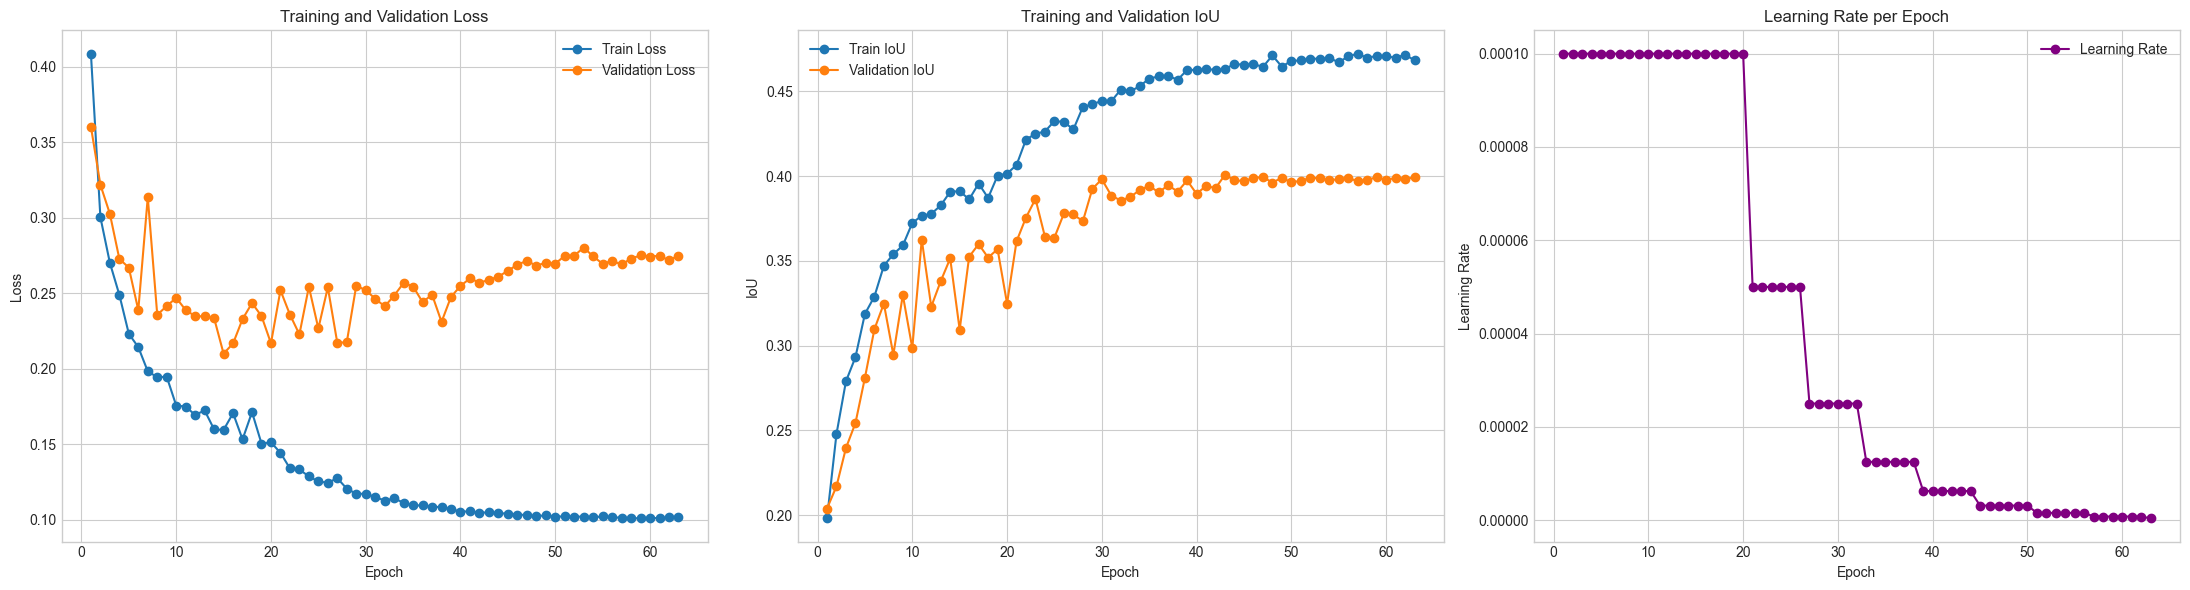

In [6]:
if __name__ == '__main__':
    train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, transform=train_transform)
    val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    model = SwinUNet_v2(input_channels=3, num_classes=1, img_size=IMG_SIZE).to(DEVICE)
    for param in model.swin.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    
    pos_weight_value = 20
    pos_weight_tensor = torch.tensor([pos_weight_value], device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(DEVICE)
    
    # Cập nhật thông báo cho chính xác
    print("="*50)
    print(f"!!! USING BCEWithLogitsLoss with pos_weight={pos_weight_value} !!!")
    print("="*50)


    print(f"Model: SwinUNet_v2 initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

    callbacks_config = {
        'patience': 20,
        'checkpoint_path': 'swin_unet_v2.pth'
    }

    # --- SỬA LỖI LOGIC TẢI CHECKPOINT ---
    start_epoch = 0
    best_val_iou = 0.0
    history = None
    checkpoint_path = callbacks_config['checkpoint_path']

    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at {checkpoint_path}. Loading to resume training...")
        # Tải checkpoint về CPU trước để tránh lỗi GPU memory
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) 
        
        # Tải trạng thái vào mô hình
        model.load_state_dict(checkpoint['model_state_dict'])
        # Đưa mô hình trở lại device (GPU/CPU)
        model.to(DEVICE)
        
        # Tải trạng thái vào optimizer và scheduler
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Cập nhật các biến để tiếp tục huấn luyện
        # Chú ý: lưu epoch đã hoàn thành, nên epoch bắt đầu tiếp theo là +1
        start_epoch = checkpoint['epoch'] + 1 
        best_val_iou = checkpoint['best_val_iou']
        history = checkpoint['history']
        
        print(f"Resuming training from Epoch {start_epoch}.")
        print(f"Best validation IoU so far: {best_val_iou:.4f}")

    else:
        print("No checkpoint found. Starting training from scratch.")

    # Cập nhật lại thông báo print cho chính xác
    print(f"\n--- Starting Swin-UNet v2 Training (BCE loss with pos_weight) ---")
    training_history = train_model(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        num_epochs=NUM_EPOCHS, callbacks_config=callbacks_config,
        start_epoch=start_epoch, best_val_iou=best_val_iou, history=history
    )
    # --- KẾT THÚC SỬA LỖI ---
    
    print("\n--- Training complete. ---")

    if training_history and len(training_history['train_loss']) > 0:
        print("Plotting training history...")
        plot_training_history(training_history)
    else:
        print("No training history available to plot.")

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            preds = (preds > threshold).float()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"IoU:       {iou:.4f}")


In [17]:
thresholds = np.arange(0.65, 1.01, 0.01)
all_preds_raw = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_preds_raw.append(probs.view(-1).cpu().numpy())
        all_targets.append(masks.view(-1).cpu().numpy())

all_preds_raw = np.concatenate(all_preds_raw)
all_targets = np.concatenate(all_targets)

metrics = {'threshold': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}

for t in thresholds:
    preds_bin = (all_preds_raw > t).astype(np.uint8)

    precision = precision_score(all_targets, preds_bin, zero_division=0)
    recall = recall_score(all_targets, preds_bin, zero_division=0)
    f1 = f1_score(all_targets, preds_bin, zero_division=0)
    iou = jaccard_score(all_targets, preds_bin, zero_division=0)

    metrics['threshold'].append(t)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['iou'].append(iou)

best_f1_idx = int(np.argmax(metrics['f1']))
best_iou_idx = int(np.argmax(metrics['iou']))

print("\n=== Threshold Tốt Nhất ===")
print(f"[F1]  Best at threshold = {metrics['threshold'][best_f1_idx]:.2f} | F1 = {metrics['f1'][best_f1_idx]:.4f}")
print(f"[IoU] Best at threshold = {metrics['threshold'][best_iou_idx]:.2f} | IoU = {metrics['iou'][best_iou_idx]:.4f}")



=== Threshold Tốt Nhất ===
[F1]  Best at threshold = 0.92 | F1 = 0.7055
[IoU] Best at threshold = 0.92 | IoU = 0.5450


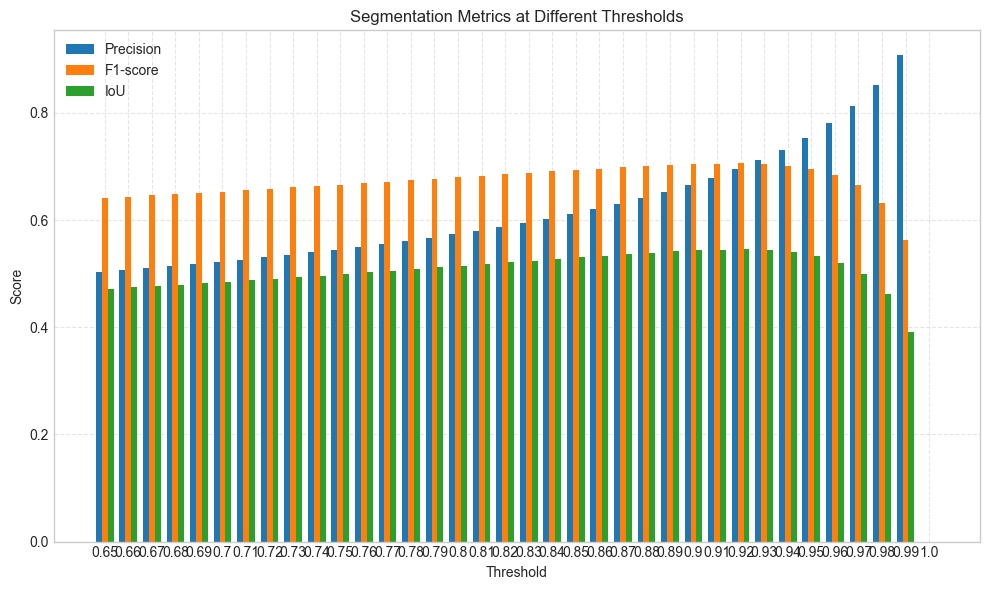

In [18]:
x = [round(t, 2) for t in metrics['threshold']]
x_idx = np.arange(len(x))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x_idx - width, metrics['precision'], width=width, label='Precision')
plt.bar(x_idx, metrics['f1'], width=width, label='F1-score')
plt.bar(x_idx + width, metrics['iou'], width=width, label='IoU')

plt.xticks(x_idx, x)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Segmentation Metrics at Different Thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()